### [ 산업 사고 사망 여부 판단 모델 ]

##### [모듈 로딩 및 데이터 로딩]

In [117]:
import pandas as pd
from sklearn.preprocessing import OneHotEncoder, LabelEncoder

In [118]:
df = pd.read_csv('./OSHA HSE DATA_ALL ABSTRACTS 15-17_FINAL.csv')

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4847 entries, 0 to 4846
Data columns (total 29 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   summary_nr            4847 non-null   int64 
 1   Event Date            4847 non-null   object
 2   Abstract Text         4847 non-null   object
 3   Event Description     4847 non-null   object
 4   Event Keywords        4847 non-null   object
 5   con_end               4847 non-null   object
 6   Construction End Use  4847 non-null   object
 7   build_stor            4847 non-null   int64 
 8   Building Stories      4847 non-null   object
 9   proj_cost             4847 non-null   object
 10  Project Cost          4847 non-null   object
 11  proj_type             4847 non-null   object
 12  Project Type          4847 non-null   object
 13  Degree of Injury      4847 non-null   object
 14  nature_of_inj         4847 non-null   int64 
 15  Nature of Injury      4845 non-null   

#### [데이터 전처리 시작] <hr>

In [119]:
# summary_nr            : 사고 레코드 고유 식별자 (ID, 분석에는 사용하지 않음)
# Event Date            : 사고 발생 날짜
# Abstract Text         : 사고 요약 설명 텍스트 (NLP용, 1차 ML에서는 미사용)
# Event Description     : 사고 상세 설명 텍스트 (NLP용)
# Event Keywords        : 사고 관련 키워드 요약

# con_end               : 공사 종료 관련 코드 (사망 여부와 직접 관련 낮음)
# Construction End Use  : 건물/시설 용도 (주거, 상업, 도로, 산업시설 등)

# build_stor            : 사고 발생 위치의 건물 층수 (0 = 지상/건물 없음)
# Building Stories      : 건물 층수의 문자열 표현 (build_stor와 중복)

# proj_cost             : 프로젝트 비용 코드 (구간형)
# Project Cost          : 프로젝트 비용 범위 (문자열 설명)

# proj_type             : 프로젝트 유형 코드
# Project Type          : 프로젝트 유형 (신축, 보수, 유지보수, 철거 등)

# Degree of Injury      : 사고 사망 여부 (Fatal / Nonfatal) → TARGET

# nature_of_inj         : 부상 유형 코드 (사고 결과 → 사용 금지)
# Nature of Injury      : 부상 유형 설명 (골절, 절단, 화상 등, 결과 변수)

# part_of_body          : 부상 부위 코드 (사고 결과)
# Part of Body          : 부상 부위 설명 (머리, 손, 다리 등)

# event_type            : 사고 유형 코드 (순서 의미 없음)
# Event type            : 사고 유형 (추락, 끼임, 충돌 등) → 핵심 FEATURE

# evn_factor            : 환경 요인 코드
# Environmental Factor  : 환경 요인 설명 (설비 배치, 날씨, 조명 등)

# hum_factor            : 인적 요인 코드
# Human Factor          : 인적 요인 설명 (부주의, 절차 미준수, 보호구 미착용 등)

# task_assigned         : 배정된 작업 수행 여부 (1=정상 작업, 2=비정상 작업)
# Task Assigned         : 작업 배정 여부 설명

# hazsub                : 유해물질 코드 (대부분 0 → 정보량 매우 적음)
# fat_cause             : 사망 원인 코드 (Fatal에서만 의미 있음)

# fall_ht               : 추락 높이 (0 = 추락 아님, 0 초과 = 추락 사고)


In [120]:
## 이상치 확인
for c in df.columns[5:] :
    print(f'[{c}] ------------- {df[c].nunique()}')
    print(f'{df[c].value_counts()}')
    print()

[con_end] ------------- 18
con_end
0    3820
C     279
A     193
H     139
B     132
I      84
D      39
M      34
P      32
G      20
J      20
O      17
Q       9
E       8
F       7
K       6
N       6
L       2
Name: count, dtype: int64

[Construction End Use] ------------- 18
Construction End Use
                                         3820
Commercial building                       279
Single family or duplex dwelling          193
Other building                            139
Multi-family dwelling                     132
Highway, road, street                      84
Manufacturing plant                        39
Pipeline                                   34
Other heavy construction                   32
Sewer/water treatment plant                20
Bridge                                     20
Power line, transmission line              17
Contractor's yard/facility                  9
Refinery                                    8
Power plant                                 7
Tower, 

In [121]:
## 정확한 매핑 값인지 확인
# event_type	    Event type                  사고 유형
# evn_factor	    Environmental Factor        환경 요인(미끄러움, 기상, 조명)
# hum_factor	    Human Factor	            인적요인 (부주의, 절차 미준수)
# task_assigned	    Task Assigned               사고 발생 시 작업 내용
# nature_of_inj	    Nature of Injury            부상 유형


col = [ ['event_type', 'Event type'],
        ['evn_factor', 'Environmental Factor'],
        ['hum_factor','Human Factor'],
        ['task_assigned','Task Assigned'],
        ['nature_of_inj','Nature of Injury' ]]

for c in col :
    print(c[1], "-----------------------")
    print(df.groupby(c[1])[c[0]].nunique())
    print()

Event type -----------------------
Event type
Absorption                   1
Bite/sting/scratch           1
Card-vascular/resp. fail.    1
Caught in or between         1
Fall (from elevation)        1
Fall (same level)            1
Ingestion                    1
Inhalation                   1
Other                        1
Rep. Motion/pressure         1
Rubbed/abraded               1
Shock                        1
Struck against               1
Struck-by                    1
Name: event_type, dtype: int64

Environmental Factor -----------------------
Environmental Factor
Catch Point/Puncture Action               1
Chemical Action/Reaction Expos            1
Flammable Liquid/Solid Exposure           1
Flying Object Action                      1
Gas/Vapor/Mist/Fume/Smoke/Dust            1
Illumination                              1
Materials Handling Equip./Method          1
Other                                     1
Overhead Moving/Falling Object Action     1
Overpressure/Underpressure

In [122]:
## 필요없는 컬럼 선정

## 사망과 전혀 관련 없음
# summary_nr            : 사고 레코드 고유 식별자 (ID, 분석에는 사용하지 않음)
# Event Date            : 사고 발생 날짜
# Abstract Text         : 사고 요약 설명 텍스트 (NLP용, 1차 ML에서는 미사용)
# Event Description     : 사고 상세 설명 텍스트 (NLP용)
# Event Keywords        : 사고 관련 키워드 요약
# con_end               : 공사 종료 관련 코드 (사망 여부와 직접 관련 낮음)
# Construction End Use  : 건물/시설 용도 (주거, 상업, 도로, 산업시설 등)
# task_assigned         : 배정된 작업 수행 여부 (1=정상 작업, 2=비정상 작업)
# Task Assigned         : 작업 배정 여부 설명


## 중복 데이터
# Building Stories      : 건물 층수의 문자열 표현 (build_stor와 중복)
# proj_cost             : 프로젝트 비용 코드 (구간형)
# proj_type             : 프로젝트 유형 코드
# nature_of_inj         : 부상 유형 코드 (사고 결과 → 사용 금지)
# part_of_body          : 부상 부위 코드 (사고 결과)
# event_type            : 사고 유형 코드 (순서 의미 없음)
# evn_factor            : 환경 요인 코드
# hum_factor            : 인적 요인 코드


## 타겟 컬럼과 관련됨()
# fat_cause             : 사망 원인 코드 (Fatal에서만 의미 있음)

## 데이터 이상함
# fall_ht               : 추락 높이 (0 = 추락 아님, 0 초과 = 추락 사고) -> 싹다 0
# hazsub                : 유해물질 코드 (대부분 0 → 정보량 매우 적음)


## 사용 컬럼

# build_stor            : 사고 발생 위치의 건물 층수 (0 = 지상/건물 없음)
# Project Type          : 프로젝트 유형 (신축, 보수, 유지보수, 철거 등)
# Degree of Injury      : 사고 사망 여부 (Fatal / Nonfatal) → TARGET
# Nature of Injury      : 부상 유형 설명 (골절, 절단, 화상 등, 결과 변수)
# Part of Body          : 부상 부위 설명 (머리, 손, 다리 등)
# Event type            : 사고 유형 (추락, 끼임, 충돌 등) → 핵심 FEATURE
# Environmental Factor  : 환경 요인 설명 (설비 배치, 날씨, 조명 등)
# Human Factor          : 인적 요인 설명 (부주의, 절차 미준수, 보호구 미착용 등)



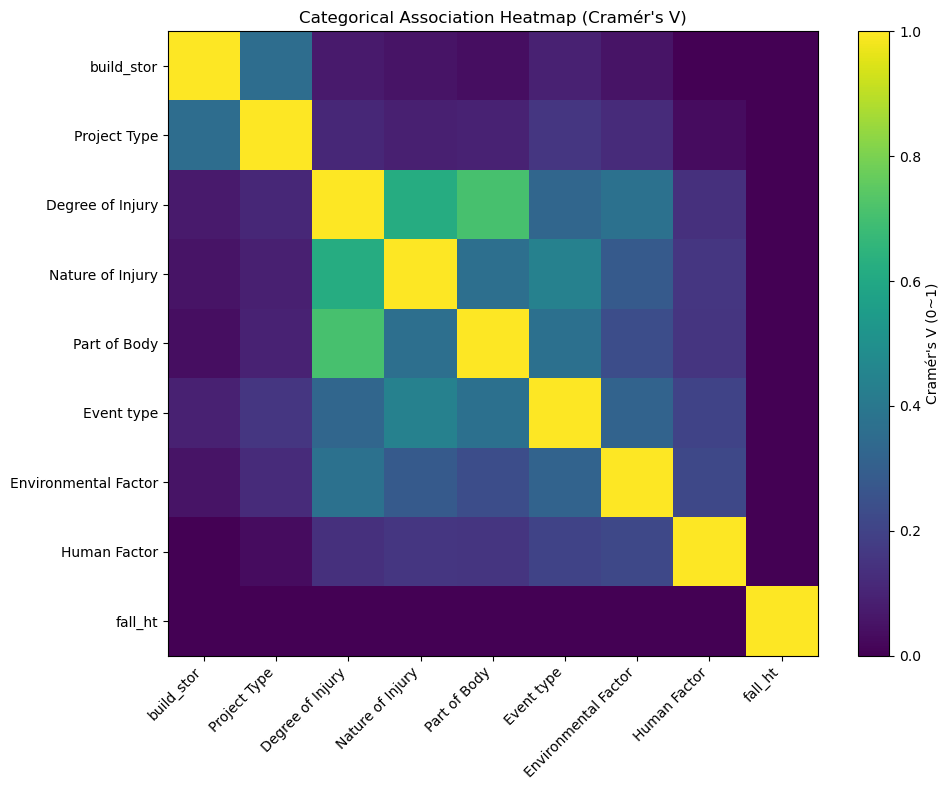

In [123]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import chi2_contingency

# =========================
# 1) Cramér's V 함수
# =========================
def cramers_v(x, y):
    """
    범주형-범주형 연관성 (0~1)
    0: 연관 없음, 1: 매우 강함
    """
    confusion = pd.crosstab(x, y)

    # 한쪽이 전부 결측/단일값이면 계산 불가 → 0 반환
    if confusion.shape[0] < 2 or confusion.shape[1] < 2:
        return 0.0

    chi2 = chi2_contingency(confusion, correction=False)[0]
    n = confusion.values.sum()

    r, k = confusion.shape
    phi2 = chi2 / n

    # bias correction (권장)
    phi2_corr = max(0, phi2 - ((k - 1) * (r - 1)) / (n - 1))
    r_corr = r - ((r - 1) ** 2) / (n - 1)
    k_corr = k - ((k - 1) ** 2) / (n - 1)

    denom = min((k_corr - 1), (r_corr - 1))
    if denom <= 0:
        return 0.0

    return np.sqrt(phi2_corr / denom)

# =========================
# 2) 분석할 컬럼 선택
#   (네가 쓰는 컬럼 그대로)
# =========================
cat_cols = [
    'build_stor',
    'Project Type',
    'Degree of Injury',
    'Nature of Injury',
    'Part of Body',
    'Event type',
    'Environmental Factor',
    'Human Factor',
    'fall_ht'
]

# 결측 통일
tmp = df[cat_cols].copy()
tmp = tmp.fillna("Unknown").astype(str)

# =========================
# 3) Cramér's V 행렬 계산
# =========================
n = len(cat_cols)
V = pd.DataFrame(np.zeros((n, n)), index=cat_cols, columns=cat_cols)

for i in range(n):
    for j in range(n):
        if i == j:
            V.iloc[i, j] = 1.0
        else:
            V.iloc[i, j] = cramers_v(tmp.iloc[:, i], tmp.iloc[:, j])

# =========================
# 4) 히트맵 시각화
# =========================
plt.figure(figsize=(10, 8))
plt.imshow(V.values, aspect='auto')
plt.xticks(range(n), cat_cols, rotation=45, ha='right')
plt.yticks(range(n), cat_cols)
plt.colorbar(label="Cramér's V (0~1)")
plt.title("Categorical Association Heatmap (Cramér's V)")
plt.tight_layout()
plt.show()

In [124]:
## 사용할 컬럼 필터링
## 타겟 컬럼은 'Nonfatal': 0, 'Fatal': 1으로 매핑
df['Degree of Injury'] = df['Degree of Injury'].map({'Nonfatal': 0, 'Fatal': 1})
print(df ['Degree of Injury'])

# 
selected_cols = [
    'build_stor',
    'Project Type',
    'Degree of Injury',
    'Nature of Injury',
    'Part of Body',
    'Event type',
    'Environmental Factor',
    'Human Factor'
]

# selected_cols = [
#     'Degree of Injury',
    
#     'Nature of Injury',
#     'Part of Body',
# ]

dataDF = df[selected_cols]
# dataDF.dropna()
dataDF.info()

0       0
1       0
2       0
3       1
4       0
       ..
4842    1
4843    1
4844    1
4845    1
4846    1
Name: Degree of Injury, Length: 4847, dtype: int64
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4847 entries, 0 to 4846
Data columns (total 8 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   build_stor            4847 non-null   int64 
 1   Project Type          4847 non-null   object
 2   Degree of Injury      4847 non-null   int64 
 3   Nature of Injury      4845 non-null   object
 4   Part of Body          4845 non-null   object
 5   Event type            4845 non-null   object
 6   Environmental Factor  4840 non-null   object
 7   Human Factor          4840 non-null   object
dtypes: int64(2), object(6)
memory usage: 303.1+ KB


In [125]:
## 타겟, 피쳐 분리

targetSR = dataDF['Degree of Injury']
featureDF = dataDF.drop(columns='Degree of Injury')
print(featureDF.isna().sum())
print("targetSR.shape :",targetSR.shape)
print("featureDF.shape :",featureDF.shape)

build_stor              0
Project Type            0
Nature of Injury        2
Part of Body            2
Event type              2
Environmental Factor    7
Human Factor            7
dtype: int64
targetSR.shape : (4847,)
featureDF.shape : (4847, 7)


In [126]:
## 모듈 로딩
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(featureDF, targetSR,
                                                    test_size=0.2,
                                                    random_state=42,
                                                    stratify=targetSR)
print("x_train.shape :",x_train.shape)
print("x_test.shape :",x_test.shape)

x_train.shape : (3877, 7)
x_test.shape : (970, 7)


In [127]:
import warnings
warnings.filterwarnings("ignore")

from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.utils import all_estimators
from sklearn.model_selection import StratifiedKFold, cross_val_score

cat_cols = [
    'build_stor',
    'Project Type',
    'Nature of Injury',
    'Part of Body',
    'Event type',
    'Environmental Factor',
    'Human Factor'
]

# cat_cols = [

#     'Nature of Injury',
#     'Part of Body',

# ]

preprocessor = ColumnTransformer(
    transformers=[('cat', OneHotEncoder(handle_unknown='ignore'), cat_cols)]
)

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

results = []
for name, Estimator in all_estimators(type_filter="classifier"):
    try:
        model = Estimator()
        pipe = Pipeline(steps=[
            ("preprocess", preprocessor),
            ("model", model)
        ])
        ## 실제 사망인 경우를 얼마나 놓치지 않고 잡았는가? ==> recall 사용
        scores = cross_val_score(pipe, x_train, y_train, cv=cv, scoring="recall")
        results.append((name, scores.mean()))
    except Exception:
        pass

sorted(results, key=lambda x: x[1], reverse=True)[:20]


[('DummyClassifier', np.float64(1.0)),
 ('NuSVC', np.float64(0.9464339329335998)),
 ('GradientBoostingClassifier', np.float64(0.9253439928936265)),
 ('LogisticRegression', np.float64(0.9245018876304686)),
 ('LogisticRegressionCV', np.float64(0.9245001110370865)),
 ('CalibratedClassifierCV', np.float64(0.9207070841661114)),
 ('MultinomialNB', np.float64(0.919438596491228)),
 ('RadiusNeighborsClassifier', np.float64(nan)),
 ('SVC', np.float64(0.9320914945591827)),
 ('RidgeClassifierCV', np.float64(0.9190202087497225)),
 ('RidgeClassifier', np.float64(0.9169140572951366)),
 ('LinearSVC', np.float64(0.9169105041083722)),
 ('KNeighborsClassifier', np.float64(0.914379746835443)),
 ('RandomForestClassifier', np.float64(0.9135358649789029)),
 ('BernoulliNB', np.float64(0.9114243837441706)),
 ('SGDClassifier', np.float64(0.908477015323118)),
 ('LabelSpreading', np.float64(0.9076331334665779)),
 ('ExtraTreesClassifier', np.float64(0.9013084610259827)),
 ('ComplementNB', np.float64(0.894557406173

In [128]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix

final_model = Pipeline(steps=[
    ("preprocess", preprocessor),
    ("model", LogisticRegression(max_iter=10000))
])

final_model.fit(x_train, y_train)

y_pred = final_model.predict(x_test)

print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))


[[292  85]
 [ 37 556]]
              precision    recall  f1-score   support

           0       0.89      0.77      0.83       377
           1       0.87      0.94      0.90       593

    accuracy                           0.87       970
   macro avg       0.88      0.86      0.86       970
weighted avg       0.88      0.87      0.87       970



#### 선택 1. LogisticRegression <hr>
- SVC와 0.02 정도의 차이
- 하지만 SVC는 블랙박스형 모델
- 어떤 요인이 사망 확률을 증가 시키는가? => 로지스틱 회귀가 가장 직관적

In [129]:
# ================================
# Logistic Regression Hyperparameters 설명
# ================================

# [1] solver
# 최적화 알고리즘 선택
# - liblinear : 
#     · 소규모 데이터, 희소 행렬(One-Hot)에 매우 안정적
#     · L1, L2 penalty 지원
#     · binary classification에 특히 강함
#
# - saga :
#     · 대규모 데이터, 고차원 원-핫 데이터에 적합
#     · L1 / L2 / ElasticNet 모두 지원
#     · 확률적 경사하강법 기반 → 일반화 성능 향상 가능
#
# ✔ 현재 데이터(원-핫 + 수천 차원)에서는 saga가 의미 있음

# [2] penalty
# 정규화(Regularization) 방식
#
# - l1 (Lasso):
#     · 중요하지 않은 feature의 계수를 0으로 만듦
#     · Feature Selection 효과
#     · 해석력 ↑
#
# - l2 (Ridge):
#     · 모든 feature를 조금씩 사용
#     · 과적합 방지, 안정적
#
# - elasticnet:
#     · l1 + l2 혼합
#     · 고차원 데이터에서 가장 강력한 경우 많음
#
# ✔ 사망 예측 + 해석 목적 → l1 / elasticnet 매우 의미 있음

# [3] C
# 규제 강도의 역수 (Inverse of Regularization Strength)
#
# - C ↓ (작을수록):
#     · 규제 강함
#     · 단순한 모델
#     · 과적합 방지
#
# - C ↑ (클수록):
#     · 규제 약함
#     · 복잡한 모델
#
# ✔ One-Hot 컬럼 많을수록 작은 C 값이 유리한 경우 많음

# [4] class_weight
# 클래스 불균형 처리
#
# - None:
#     · 모든 샘플 동일 가중치
#
# - "balanced":
#     · 클래스 빈도에 반비례한 가중치 자동 부여
#     · 소수 클래스(Fatal)를 더 중요하게 학습
#
# ✔ 사망(Fatal)을 놓치지 않는 것이 목표 → 반드시 포함해야 함

# [5] l1_ratio
# ElasticNet에서 L1 비중
#
# - 0.1 : 거의 L2 (안정성 위주)
# - 0.5 : L1 / L2 균형
# - 0.9 : 거의 L1 (Feature Selection 강함)
#
# ⚠ elasticnet + saga 조합에서만 의미 있음


In [177]:
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression

# score 값 -> recall 
#            사망자 맞출확률 : 0.9퍼 but, 비사망자 맞출확률 : 0.69 => 비사망자 맞출 확률 좀 낮음
#            False Positive는 감수 해야됨
#         -> recall_marco
#            사망자 맞출확률 : 0.9퍼 & 비사망자 맞출확률 : 0.8
#            균형잡힌 지표

param_grid = {
    "model__solver": ["liblinear"], 
    "model__penalty": ["l1", "l2"],
    "model__C": [0.01, 0.1, 1, 10, 100],
    "model__class_weight": [None, "balanced"],
    "model__solver": ["liblinear"]  # l1, l2 모두 지원
}

grid = GridSearchCV(
    estimator=Pipeline(steps=[
        ("preprocess", preprocessor),
        ("model", LogisticRegression(max_iter=10000))
    ]),
    param_grid=param_grid,
    scoring="recall",
    cv=cv,
    n_jobs=-1,
    verbose=1
)



In [178]:
grid.fit(x_train, y_train)

print("Best Recall:", grid.best_score_)
print("Best Params:", grid.best_params_)

## 최적 모델로 Test 성능평가

best_model = grid.best_estimator_
y_pred = best_model.predict(x_test)

print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

Fitting 5 folds for each of 20 candidates, totalling 100 fits
Best Recall: 0.9417961359093937
Best Params: {'model__C': 0.01, 'model__class_weight': None, 'model__penalty': 'l2', 'model__solver': 'liblinear'}
[[259 118]
 [ 41 552]]
              precision    recall  f1-score   support

           0       0.86      0.69      0.77       377
           1       0.82      0.93      0.87       593

    accuracy                           0.84       970
   macro avg       0.84      0.81      0.82       970
weighted avg       0.84      0.84      0.83       970



In [132]:
## 어떤 요인이 가장 사망확률을 높였을까?
feature_names = (
    best_model
    .named_steps["preprocess"]
    .named_transformers_["cat"]
    .get_feature_names_out(cat_cols)
)

coef = best_model.named_steps["model"].coef_[0]

coef_df = pd.DataFrame({
    "feature": feature_names,
    "coef": coef
}).sort_values(by="coef", ascending=False)

print('사망율을 올리는 요인')
display(coef_df.head(5))      # 사망 확률 ↑ 요인

print('사망율을 낮추는 요인')
display(coef_df.tail(5))      # 사망 확률 ↓ 요인


사망율을 올리는 요인


,feature,coef
31,"Nature of Injury_Asphyxiation, Drowning",3.316790
76,Part of Body_Whole Body,2.428608
60,Part of Body_Head,2.253322
35,Nature of Injury_Electrocution,2.247725
96,Environmental Factor_Flammable Liquid/Solid Ex...,2.015053


사망율을 낮추는 요인


,feature,coef
86,Event type_Inhalation,-1.185790
77,Part of Body_Wrist,-1.273321
59,Part of Body_Hand,-1.428390
55,Part of Body_Feet,-1.795087
57,Part of Body_Fingers,-4.447846


#### 선택 2. GradientBoostingClassifier <hr>
- 앙상블 중 1등의 정확도
- feature_importances_ 제공

In [168]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.metrics import confusion_matrix, classification_report

# 앙상블 파이프라인
gb_pipe = Pipeline(steps=[
    ("preprocess", preprocessor),
    ("model", GradientBoostingClassifier(random_state=42))
])

# 그리드 범위 (너무 크면 오래 걸리니까 "실용적으로" 잡음)
param_grid_gb = {
    "model__n_estimators": [50, 100, 200, 300],
    "model__learning_rate": [0.05, 0.1, 0.2],
    "model__max_depth": [2, 3, 4],      # base tree depth
    "model__subsample": [0.7, 0.9, 1.0] # 1.0이면 기본 GBC, 낮추면 Stochastic GB
}

gb_grid = GridSearchCV(
    estimator=gb_pipe,
    param_grid=param_grid_gb,
    scoring="recall",  
    cv=cv,
    n_jobs=-1,
    verbose=1
)



In [169]:
gb_grid.fit(x_train, y_train)

print("Best Recall:", gb_grid.best_score_)
print("Best Params:", gb_grid.best_params_)


Fitting 5 folds for each of 108 candidates, totalling 540 fits
Best Recall: 0.9637201865423052
Best Params: {'model__learning_rate': 0.05, 'model__max_depth': 2, 'model__n_estimators': 50, 'model__subsample': 0.9}


In [170]:
## 최적 모델로 Test 성능평가
best_gb = gb_grid.best_estimator_
y_pred_gb = best_gb.predict(x_test)

print(confusion_matrix(y_test, y_pred_gb))
print(classification_report(y_test, y_pred_gb))


[[200 177]
 [  8 585]]
              precision    recall  f1-score   support

           0       0.96      0.53      0.68       377
           1       0.77      0.99      0.86       593

    accuracy                           0.81       970
   macro avg       0.86      0.76      0.77       970
weighted avg       0.84      0.81      0.79       970



In [181]:
## 중요 피쳐 뽑기

# OneHot feature names
feature_names = (
    best_gb.named_steps["preprocess"]
           .named_transformers_["cat"]
           .get_feature_names_out(cat_cols)
)

# GBC feature importances
importances = best_gb.named_steps["model"].feature_importances_

imp_df = pd.DataFrame({
    "feature": feature_names,
    "importance": importances
}).sort_values("importance", ascending=False)

display(imp_df.head(5), len(imp_df))

imp_df.tail(34)


,feature,importance
57,Part of Body_Fingers,0.381448
47,Nature of Injury_Serious Fall/Strike,0.252067
60,Part of Body_Head,0.084153
76,Part of Body_Whole Body,0.050593
30,"Nature of Injury_Amputation, Crushing",0.045276


131

,feature,importance
97,Environmental Factor_Flying Object Action,0.0
70,Part of Body_Lungs (Puncture),0.0
98,Environmental Factor_Gas/Vapor/Mist/Fume/Smoke...,0.0
99,Environmental Factor_Illumination,0.0
101,Environmental Factor_Other,0.0
100,Environmental Factor_Materials Handling Equip....,0.0
102,Environmental Factor_Overhead Moving/Falling O...,0.0
103,Environmental Factor_Overpressure/Underpressure,0.0
105,Environmental Factor_Radiation Condition,0.0
106,Environmental Factor_Shear Point Action,0.0


In [179]:
# import pandas as pd
# from sklearn.model_selection import train_test_split, StratifiedKFold
# from sklearn.preprocessing import OneHotEncoder
# from sklearn.compose import ColumnTransformer
# from sklearn.pipeline import Pipeline
# from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, recall_score

# # =========================
# # 1) 원본 데이터 로드
# # =========================
# df = pd.read_csv("./OSHA HSE DATA_ALL ABSTRACTS 15-17_FINAL.csv")

# # 타겟 매핑 (Nonfatal=0, Fatal=1)
# df["Degree of Injury"] = df["Degree of Injury"].map({"Nonfatal": 0, "Fatal": 1})

feature_cols = [
    "build_stor",
    "Project Type",
    "Nature of Injury",
    "Part of Body",
    "Event type",
    "Environmental Factor",
    "Human Factor"
]
# target_col = "Degree of Injury"

# dataDF = df[feature_cols + [target_col]].dropna(subset=[target_col])  # 타겟 결측만 제거
# X = dataDF[feature_cols]
# y = dataDF[target_col]

# x_train, x_test, y_train, y_test = train_test_split(
#     X, y, test_size=0.2, random_state=42, stratify=y
# )

# # =========================
# # 2) 전처리 + 모델 (네가 고른 best params 예시)
# # =========================
# preprocessor = ColumnTransformer(
#     transformers=[("cat", OneHotEncoder(handle_unknown="ignore"), feature_cols)]
# )

# best_model = Pipeline(steps=[
#     ("preprocess", preprocessor),
#     ("model", LogisticRegression(
#         max_iter=10000,
#         solver="liblinear",
#         penalty="l1",
#         C=1,
#         class_weight="balanced"
#     ))
# ])

# best_model.fit(x_train, y_train)

# # 내부 test 평가
# pred_test = best_model.predict(x_test)
# print("=== Internal Test ===")
# print(confusion_matrix(y_test, pred_test))
# print(classification_report(y_test, pred_test))
# print("recall_macro:", recall_score(y_test, pred_test, average="macro"))

# =========================
# 3) 외부 테스트 CSV 평가
# =========================
ext = pd.read_csv("./external_test_osha_synthetic.csv")

X_ext = ext[feature_cols]
y_ext = ext['Degree of Injury']

best_gb = gb_grid.best_estimator_
best_model = grid.best_estimator_
pred_ext = best_model.predict(X_ext)




print("\n=== External Test ===")
print(confusion_matrix(y_ext, pred_ext))
print(classification_report(y_ext, pred_ext))
print("recall:", recall_score(y_ext, pred_ext))



=== External Test ===
[[ 836 1878]
 [ 525 1761]]
              precision    recall  f1-score   support

           0       0.61      0.31      0.41      2714
           1       0.48      0.77      0.59      2286

    accuracy                           0.52      5000
   macro avg       0.55      0.54      0.50      5000
weighted avg       0.55      0.52      0.49      5000

recall: 0.7703412073490814
